## Linear vs Non Linear

Can a Forward NN learn non-linear functions?
That may seem a trivial question but it is not!
First we train a CNN to classify the 10 FashionMNIST classes.

In [1]:
import torch
from torch.autograd import Variable
import numpy as np
import torch.nn.functional as F
import torchvision
from torchvision import transforms
from torchvision.utils import save_image
import torch.optim as optim
from torch import nn
import matplotlib.pyplot as plt
%matplotlib inline


# Decide if the system has GPUs
if torch.cuda.is_available():
    device = torch.device('cuda')
    dtype = torch.cuda.FloatTensor
else:
    device = torch.device('cpu')
    dtype = torch.FloatTensor

print(device)
print(dtype)

def save_everything(model_object,optimizer_object,filepath):
        """
        Save all the quantities related to model and optimizer
        """
        state = model_object.save_model()
        state['optimizer'] = optimizer_object.state_dict()
        torch.save(state, filepath)
        
def load_everything(model_object,optimizer_object,filepath):
        """
        Load all the quantities relateds to the object from file
        """
        state = torch.load(filepath,map_location='cpu')
        model_object.load_model(state)
        optimizer_object.load_state_dict(state['optimizer'])

def show_batch(images):
    """
    Simple function to show the images
    """
    im = torchvision.utils.make_grid(images)
    plt.imshow(np.transpose(im.numpy(), (1, 2, 0)))
    
def show_names(labels):
    labels_dict={
        0 : "Tshirt",
        1 : "Trouser",
        2 : "Pullover",
        3 : "Dress",
        4 : "Coat",
        5 : "Sandal",
        6 : "Shirt",
        7 : "Sneaker",
        8 : "Bag",
        9 : "Ankle boot"}
    names = []
    for i in labels:
        names.append(labels_dict[i.item()])
    print(names)

cuda
<class 'torch.cuda.FloatTensor'>


In [2]:
class CNNModule(nn.Module):
    def __init__(self,criterion):
        super().__init__()
        
        # Auxiliary variables
        self.loss_history = []
        self.epoch = 0
        self.training_time = 0
        self.criterion=criterion
               
        # First Convolution Layer. The new image size remains unchanged:
        # Floor[ (28 + 2*padding - kernel_size)/stride + 1 ] = Floor[28+4-5+1] = 28x28 
        self.cnn1 = nn.Conv2d(in_channels=1,out_channels=16,kernel_size=5,stride=1,padding=2)
        self.relu1=nn.ReLU()
        nn.init.xavier_uniform_(self.cnn1.weight)

        # The max poll with kernel_size 2 reduces the image to size 14x14
        self.maxpool1=nn.MaxPool2d(kernel_size=2)

        # Second Convolution Layer. The new image size remains unchanged:
        # Floor[ (14 + 2*padding - kernel_size)/stride + 1 ] = Floor[14+4-5+1] = 14x14 
        self.cnn2=nn.Conv2d(in_channels=16,out_channels=32,kernel_size=5,stride=1,padding=2)
        self.relu2=nn.ReLU()
        nn.init.xavier_uniform_(self.cnn2.weight)

        # The max poll with kernel_size 2 reduces the image to 7x7
        self.maxpool2=nn.MaxPool2d(kernel_size=2)

        # The last is a fully connected layer with 7x7xn_channel -> 10
        self.fcl=nn.Linear(32*7*7,10)
    
    def forward(self,x):
        #First convolution
        out=self.cnn1(x)
        out=self.relu1(out)
        # Max pool
        out=self.maxpool1(out)
        # Second convolution
        out=self.cnn2(out)
        out=self.relu2(out)
        # Second convolution
        out=self.maxpool2(out)
        # Flattening
        out=out.view(out.size(0),-1)
        # Dense lyer
        out=self.fcl(out)
        return out
    
    def save_model(self):
        state={
            'state_dict': self.state_dict(),
            'loss_history': self.loss_history,
            'epoch': self.epoch,
            'training_time' : self.training_time
        }
        return state
            
    def load_model(self,state):
        self.load_state_dict(state['state_dict'])
        self.loss_history = state['loss_history']
        self.epoch = state['epoch']
        self.training_time = state['training_time']
    
    def compute_loss(self, output, labels):
        #print("output.size()",output.shape)
        #print("labels.size()",labels.shape)
        loss = self.criterion(output,labels)
        return loss
        
    
    def train_one_epoch(self,trainloader):
        
        tmp = [] 
        for i, data in enumerate(trainloader, 0): #loop over minibatches
            
            img, labels  = data
            images_in = Variable(img.to(device),requires_grad=False) #put the data on GPU if necessary
            
            # Run the VAE forward 
            output = self.forward(images_in)
            
            # Compute the loss
            # Note that output is (nbatches,10) and labels is (nbatches)

            loss = self.compute_loss(output,labels.to(device)) 
            #print(loss)
            
            # compute the average loss in this epoch
            tmp.append(loss.item()) # add the loss to the tmp list
            
            # For each minibatch set the gradient to zero
            optimizer.zero_grad()
            loss.backward()  # do backprop and compute all the gradients
            optimizer.step() # update the parameters
            
        # Svae the average loss during the epoch and the final value at the end of epoch
        self.loss_history.append(np.mean(tmp))
        self.epoch += 1
        
        
    def train(self,trainloader,DELTA_EPOCHS):
        import timeit
        tic=timeit.default_timer()
        
        for nn in range(DELTA_EPOCHS):
            self.train_one_epoch(trainloader)
            print("EPOCH loss=",self.epoch,self.loss_history[-1])
        
        toc=timeit.default_timer()
        self.training_time += toc - tic

1 28 28
['Ankle boot', 'Pullover', 'Trouser', 'Trouser', 'Shirt', 'Trouser', 'Coat', 'Shirt', 'Sandal', 'Sneaker', 'Coat', 'Sandal', 'Sneaker', 'Dress', 'Coat', 'Trouser', 'Pullover', 'Coat', 'Bag', 'Tshirt', 'Pullover', 'Sandal', 'Sneaker', 'Ankle boot', 'Trouser', 'Coat', 'Shirt', 'Tshirt', 'Ankle boot', 'Dress', 'Bag', 'Bag', 'Dress', 'Dress', 'Bag', 'Tshirt', 'Sneaker', 'Sandal', 'Sneaker', 'Ankle boot', 'Shirt', 'Trouser', 'Dress', 'Sneaker', 'Shirt', 'Sneaker', 'Pullover', 'Trouser', 'Pullover', 'Pullover', 'Coat', 'Coat', 'Sandal', 'Bag', 'Pullover', 'Pullover', 'Bag', 'Coat', 'Bag', 'Tshirt', 'Sneaker', 'Sneaker', 'Bag', 'Sandal']


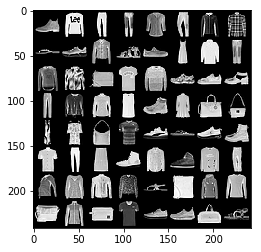

In [3]:
if __name__ == '__main__':
    
   
    BATCH_SIZE = 64

    transform = transforms.ToTensor()
    #transform=transforms.Compose([transforms.ToTensor(),transforms.Normalize((0.1307,), (0.3081,))])

    # Load and transform data
    trainset = torchvision.datasets.FashionMNIST('./data', train=True, download=True, transform=transform)
    trainloader = torch.utils.data.DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True)

    testset = torchvision.datasets.FashionMNIST('./data', train=False, download=True, transform=transform)
    testloader = torch.utils.data.DataLoader(testset, batch_size=BATCH_SIZE, shuffle=False)
    
    # Visualize the data and extract the image size
    images, labels =next(iter(trainloader))
    _, n_channel, height, width = images.size()
    print(n_channel,height, width)
   

    # Instanciates the CNN
    criterion=nn.CrossEntropyLoss() #it combines softmax and categorical entropy. 
                                    # This is why I do not have softmax in definition of forward pass 
    cnn = CNNModule(criterion).to(device) #note that here I am creating the model to either gpu or cpu
    
    # Select the optimizer
    #optimizer = optim.Adam(vae.parameters(), lr=0.0001)
    #optimizer = optim.RMSprop(vae.parameters())
    optimizer=torch.optim.SGD(cnn.parameters(),lr=0.015)
    

    # Save the same set of test images for testing   
    images_test_in, labels_test  = next(iter(testloader))
    
    # Look at the data
    show_batch(images_test_in)
    show_names(labels_test)
    

In [4]:
    for k in range(0,4):
        if(k>0):
            load_everything(cnn,optimizer,'./cnn'+str(k-1)+'.pth')
        
        cnn.train(trainloader,10)  # train the model for 10 EPOCHS 
        save_everything(cnn,optimizer,'./cnn'+str(k)+'.pth')

        # Evaluate the accuracy on the test set
        with torch.no_grad():
            correct=0
            total=0
            for i, data in enumerate(testloader, 0):
                img,labels = data
                images_in = Variable(img.to(device),requires_grad=False) 
                output = cnn(images_in)              
                _,predicted=torch.max(output.data,1)
                total+=labels.size(0)
                correct+=(predicted==labels.to(device)).sum()
            accuracy= (100.0* correct)/(total)
            print("Iteration:"+str(cnn.epoch)+"  Loss:"+str(cnn.loss_history[-1])+"  Accuracy:"+str(accuracy.item()))
            

EPOCH loss= 1 0.8974550875392295
EPOCH loss= 2 0.5259852915017336
EPOCH loss= 3 0.44479694724210034
EPOCH loss= 4 0.40781596793866615
EPOCH loss= 5 0.3855681928522043
EPOCH loss= 6 0.3689192202347301
EPOCH loss= 7 0.35419173308336405
EPOCH loss= 8 0.34357135360047764
EPOCH loss= 9 0.33173460217077594
EPOCH loss= 10 0.3247651066194211
Iteration:10  Loss:0.3247651066194211  Accuracy:83
EPOCH loss= 11 0.31704761472338044
EPOCH loss= 12 0.3099238667200242
EPOCH loss= 13 0.303913670951433
EPOCH loss= 14 0.2992909886340088
EPOCH loss= 15 0.292028061370415
EPOCH loss= 16 0.28878589652812303
EPOCH loss= 17 0.28371439482579863
EPOCH loss= 18 0.2792446961614496
EPOCH loss= 19 0.2756684432898376
EPOCH loss= 20 0.27101211731971453
Iteration:20  Loss:0.27101211731971453  Accuracy:89
EPOCH loss= 21 0.26681977397660966
EPOCH loss= 22 0.2638899091480256
EPOCH loss= 23 0.2606015589826905
EPOCH loss= 24 0.2574877885978486
EPOCH loss= 25 0.25370518272238246
EPOCH loss= 26 0.2504526349161861
EPOCH loss= 2

Text(0,0.5,'Loss')

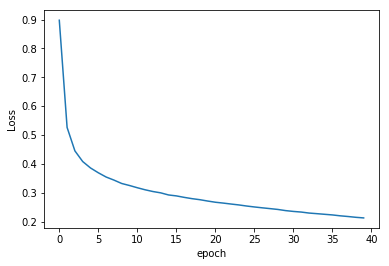

In [5]:
plt.plot(cnn.loss_history)
plt.xlabel("epoch")
plt.ylabel("Loss")

Cool! We have achieved 90% accuracy on this data set.
**Now we analyze how the probability for the 10 classes change as a function of the input.**
We try:

\begin{equation}
\vec{y} = \text{CNN}(x +\epsilon \Delta x)
\end{equation}

where $\vec{y}$ is the 10 dimensional vector containing the probabilities for each class, $x$ is a test image which gave the right output and $\Delta x$ is a random 28x28 image

[[-3.2414932  -9.314419   -4.927745   -5.00008    -8.517282    7.0590267
  -0.74317557  6.9669433   3.3509905  12.345202  ]]
[9]
['Ankle boot']
          0         1         2        3         4         5         6  \
0 -3.241493 -9.314419 -4.927745 -5.00008 -8.517282  7.059027 -0.743176   

          7         8          9  
0  6.966943  3.350991  12.345202  


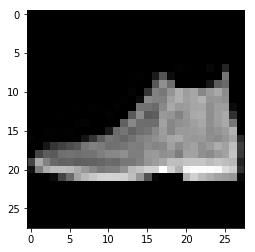

In [6]:
import pandas as pd

with torch.no_grad():
    
    # Load images 1 by 1 till you find one that is correctly predicted.
    # Then save that image and its probability for the 10 classes into data frame
    
    testloader_1_image = torch.utils.data.DataLoader(testset, batch_size=1, shuffle=False)
    for i in range(0,1):
        img, label = next(iter(testloader_1_image))
        output = cnn(img.to(device)) 
        _,predicted=torch.max(output.data,1)
        if(predicted==label.to(device)):
            base_img=img.to(device)
            base_prob=output.cpu().numpy()
            base_label=predicted.cpu().numpy()
            print(base_prob)
            print(base_label)
            show_names(base_label)
            show_batch(img)
            df = pd.DataFrame(base_prob)
            break
print(df)

In [7]:
with torch.no_grad():
    random_image = np.random.rand(height,width).astype(np.float32)
    #plt.imshow(random_image)
    dx=torch.from_numpy(np.reshape(random_image,img.size())).to(device)
    
    #print(base_img.dtype,base_img.size(),base_img.device) 
    #print(dx.dtype,dx.size(),dx.device) 
    epsilon = [0]
    for nep in range(1,10):
        ep = nep*0.1
        epsilon.append(ep)
        output_dx = cnn(base_img+ep*dx)
        df_tmp = pd.DataFrame(output_dx.cpu().numpy())
        #print(df_tmp)
        df=df.append(df_tmp,ignore_index=True)
        #df.append(pd.Series(), ignore_index=True)
    
    # Now add the column with the value of epsilon
    # and change the columns names
    eps = pd.Series(epsilon)
    df = df.assign(eps=eps.values)
    df=df.rename(index=str, columns={0: "p0", 1: "p1",2: "p2", 3: "p3",4: "p4", 5: "p5",6: "p6", 7: "p7",8: "p8", 9: "p9"})

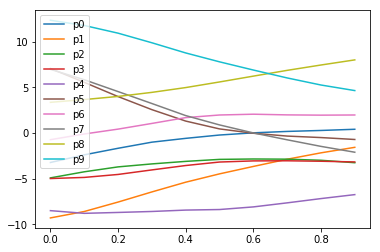

In [9]:
#print(df)
plt.plot( 'eps', 'p0', data=df)
plt.plot( 'eps', 'p1', data=df)
plt.plot( 'eps', 'p2', data=df)
plt.plot( 'eps', 'p3', data=df)
plt.plot( 'eps', 'p4', data=df)
plt.plot( 'eps', 'p5', data=df)
plt.plot( 'eps', 'p6', data=df)
plt.plot( 'eps', 'p7', data=df)
plt.plot( 'eps', 'p8', data=df)
plt.plot( 'eps', 'p9', data=df)
plt.legend()